<a href="https://colab.research.google.com/github/sway-am/interpretability_PV_detection/blob/main/GradCam_on_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! ls

gdrive	sample_data


In [5]:
%cd /content/gdrive/MyDrive/project_folder2

/content/gdrive/MyDrive/project_folder2


In [10]:
! git clone https://github.com/zae-bayern/elpv-dataset.git

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2695, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2695 (delta 2), reused 1 (delta 1), pack-reused 2691
Receiving objects: 100% (2695/2695), 90.79 MiB | 21.15 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (2629/2629), done.


In [11]:
#code copied from the utils file
from PIL import Image
import numpy as np
import os


def load_dataset(fname=None):
    if fname is None:
        # Assume we are in the utils folder and get the absolute path to the
        # parent directory.
        __file__ = '/content/gdrive/MyDrive/project_folder2/elpv-dataset/doc'
        fname = os.path.abspath(os.path.join(__file__,
                                             os.path.pardir))
        fname = os.path.join(fname, 'labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    return images, probs, types

In [12]:
images, proba, types = load_dataset()

In [13]:
import cv2
import numpy as np



# Create an empty numpy array to store the resized images
resized_images = np.empty((2624, 120, 120))

# Loop through each image in the 'images' array and resize it
for i in range(images.shape[0]):
    # Resize the image using OpenCV
    resized_image = cv2.resize(images[i], (120, 120))

    # Store the resized image in the new array
    resized_images[i] = resized_image

del images

images = resized_images


In [14]:
new_types = []
for i in range(types.shape[0]):
  if types[i] == "mono":
    new_types.append(0)
  else:
    new_types.append(1)

In [15]:
new_types =np.array(new_types)

In [16]:
types = new_types
types

array([0, 0, 0, ..., 1, 1, 1])

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( images, types, test_size=0.2, random_state=42)

In [18]:
X_train = X_train.reshape((-1,120,120,1)).astype('float32') / 255.0
X_test = X_test.reshape((-1,120,120,1)).astype('float32') / 255.0

In [19]:
X_train.shape

(2099, 120, 120, 1)

In [26]:
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 120,120, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

In [27]:
X_train.shape

(2099, 120, 120, 3)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [35]:
model = Sequential()

model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Flatten())
model.add(Dense(units = 16 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1 , activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 60, 60, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 32)       

In [36]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [37]:
history = model.fit(X_train,y_train, batch_size = 16 ,epochs = 10 ,validation_data = (X_test, y_test))

Epoch 1/10
132/132 [==============================] - 4s 15ms/step - loss: 0.5262 - accuracy: 0.6975 - val_loss: 0.2256 - val_accuracy: 0.9829
Epoch 2/10
132/132 [==============================] - 1s 9ms/step - loss: 0.2142 - accuracy: 0.9628 - val_loss: 0.0804 - val_accuracy: 0.9905
Epoch 3/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1409 - accuracy: 0.9890 - val_loss: 0.0466 - val_accuracy: 0.9981
Epoch 4/10
132/132 [==============================] - 1s 6ms/step - loss: 0.1237 - accuracy: 0.9976 - val_loss: 0.0181 - val_accuracy: 0.9981
Epoch 5/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1115 - accuracy: 0.9981 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 6/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1098 - accuracy: 0.9976 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 7/10
132/132 [==============================] - 1s 7ms/step - loss: 0.0989 - accuracy: 0.9995 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch

In [38]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
predictions = predictions.reshape(1, -1)[0]

17/17 [==============================] - 0s 5ms/step


In [39]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predictions, target_names = ['mono','poly']))

              precision    recall  f1-score   support

        mono       1.00      1.00      1.00       216
        poly       1.00      1.00      1.00       309

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



In [40]:
from tensorflow.keras.models import Model
import cv2


def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model


    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])

    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap


In [41]:

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):

    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.


    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Text(0.5, 1.0, 'conv2d_8 Grad-CAM heat-map')

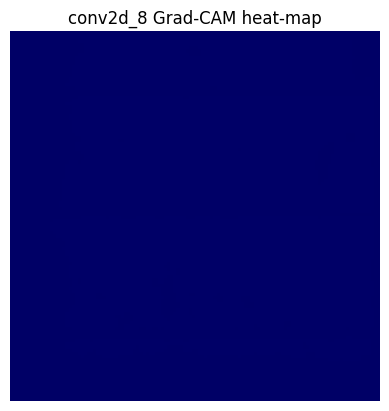

In [57]:
## Grad-CAM heatmap for the last convolutional layer in the model, conv2d_8

i = 60
img = X_train[i]
layer_name = 'conv2d_8'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)




plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('conv2d_8 Grad-CAM heat-map')




Text(0.5, 1.0, 'max_pooling2d_8 Grad-CAM heat-map')

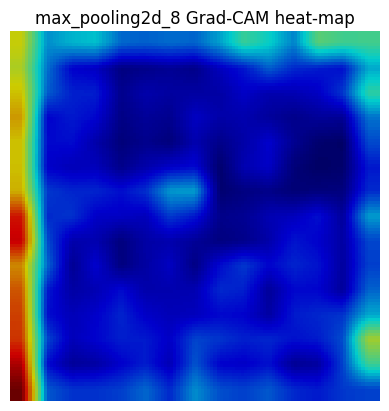

In [65]:
## Grad-CAM heatmap for the last convolutional layer in the model, max_pooling2d_8

i = 59
img = X_train[i]
layer_name = 'max_pooling2d_8'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)




plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('max_pooling2d_8 Grad-CAM heat-map')




Text(0.5, 1.0, 'max_pooling2d_8 Grad-CAM heat-map')

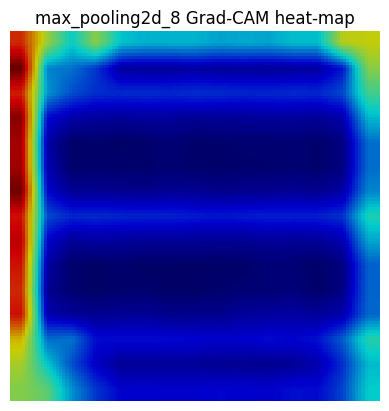

In [66]:
## Grad-CAM heatmap for the last convolutional layer in the model, max_pooling2d_8

i = 10
img = X_train[i]
layer_name = 'max_pooling2d_8'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)




plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('max_pooling2d_8 Grad-CAM heat-map')



Text(0.5, 1.0, 'max_pooling2d_8 Grad-CAM heat-map')

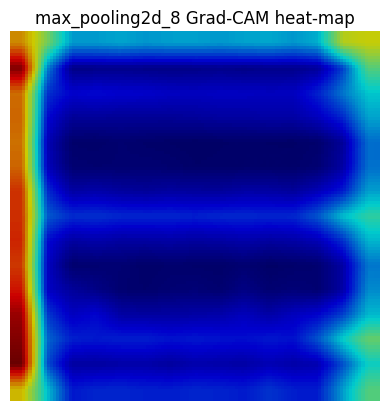

In [68]:
## Grad-CAM heatmap for the last convolutional layer in the model, max_pooling2d_8

i = 2
img = X_train[i]
layer_name = 'max_pooling2d_8'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)




plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('max_pooling2d_8 Grad-CAM heat-map')



Text(0.5, 1.0, 'max_pooling2d_8 Grad-CAM heat-map')

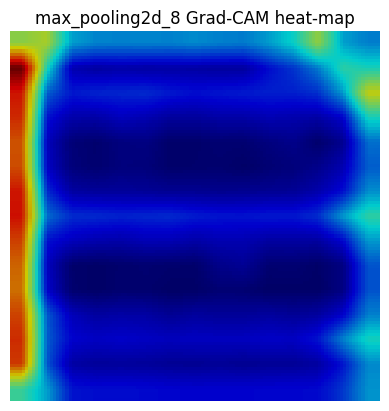

In [69]:
## Grad-CAM heatmap for the last convolutional layer in the model, max_pooling2d_8

i = 3
img = X_test[i]
layer_name = 'max_pooling2d_8'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)




plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('max_pooling2d_8 Grad-CAM heat-map')



Text(0.5, 1.0, 'max_pooling2d_8 Grad-CAM heat-map')

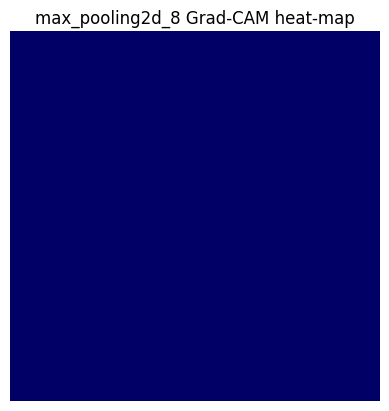

In [72]:
## Grad-CAM heatmap for the last convolutional layer in the model, max_pooling2d_8

i = 60
img = X_train[i]
layer_name = 'max_pooling2d_8'
grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=False)




plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('max_pooling2d_8 Grad-CAM heat-map')

